# Determine Contribution of Metadata to Feature Differences

We perform an analysis of variance (ANOVA) model to determine if metadata information or real biology treatments contribute to observed differences in each cell painting feature.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(broom))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))

source(file.path("scripts", "signature_utils.R"))

In [2]:
input_data_dir = "data"
output_fig_dir = file.path("figures", "anova")
output_results_dir = file.path("results", "signatures")

## Load Profiles

In [3]:
bulk_col_types <- readr::cols(
    .default = readr::col_double(),
    Metadata_plate_map_name = readr::col_character(),
    Metadata_clone_number = readr::col_character(),
    Metadata_plate_ID = readr::col_character(),
    Metadata_treatment = readr::col_character(),
    Metadata_Plate = readr::col_character(),
    Metadata_Well = readr::col_character(),
    Metadata_batch = readr::col_character(),
    Metadata_clone_type = readr::col_character()
)

In [4]:
bulk_file <- file.path(input_data_dir, "bulk_profiles_four_clone.csv.gz")
bulk_df <- readr::read_csv(bulk_file, col_types=bulk_col_types)

# Select only DMSO treated wells and drop WT_parental
bulk_df <- bulk_df %>%
    dplyr::filter(
        Metadata_treatment == "DMSO",
        Metadata_clone_number != "WT_parental"
    )

print(dim(bulk_df))
head(bulk_df, 3)

[1] 168 162


Metadata_plate_map_name,Metadata_clone_number,Metadata_plate_ID,Metadata_treatment,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_clone_type,Cells_AreaShape_Compactness,Cells_AreaShape_Extent,⋯,Nuclei_RadialDistribution_RadialCV_RNA_1of4,Nuclei_Texture_Correlation_AGP_20_00,Nuclei_Texture_Correlation_AGP_20_03,Nuclei_Texture_Correlation_AGP_5_00,Nuclei_Texture_InfoMeas1_DNA_10_02,Nuclei_Texture_InfoMeas1_DNA_5_00,Nuclei_Texture_InfoMeas1_Mito_10_00,Nuclei_Texture_InfoMeas1_Mito_5_00,Nuclei_Texture_InfoMeas2_DNA_5_00,Nuclei_Texture_SumAverage_DNA_20_00
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WTmut04hWed,BZ017,217744,DMSO,WTmut04hWed,B02,2019_11_11_Batch4,resistant,-0.01303059,-0.5523749,⋯,-0.03635861,0.2679976,-0.4790670,0.4322077,1.294007,1.0708710,0.4545383,-0.3880047,-1.567204e+00,-1.12499540
WTmut04hWed,WT002,217744,DMSO,WTmut04hWed,B03,2019_11_11_Batch4,sensitive,0.54014849,-0.6885712,⋯,0.52409572,-0.8468926,-0.8868938,-0.7533647,1.755599,-0.7155806,1.5965876,-0.1304379,6.817705e-05,-1.11491248
WTmut04hWed,WT008,217744,DMSO,WTmut04hWed,B04,2019_11_11_Batch4,sensitive,-1.80168074,0.9674189,⋯,-0.99071447,-0.5184313,-0.5450562,0.5739463,0.788443,-0.4182176,1.1016913,-0.3146864,-2.380096e-02,-0.09052916


In [5]:
table(
    bulk_df$Metadata_clone_number,
    bulk_df$Metadata_treatment
    )
    

       
        DMSO
  BZ001   21
  BZ008   21
  BZ017   21
  BZ018   21
  WT002   21
  WT008   21
  WT009   21
  WT011   21

### Fit linear model to determine sources of variation

In [6]:
formula_terms <- paste(
    "~",
    "Metadata_clone_type", "+",
    "Metadata_batch", "+",
    "Metadata_Plate", "+",
    "Metadata_clone_number"
)

lm_results <- perform_anova(bulk_df, formula_terms)

### Process Results - Metadata Variation

In [7]:
full_results_df <- lm_results[["full_results_df"]]

full_results_df$term <- factor(
    full_results_df$term, levels = c(
        "Metadata_batch",
        "Metadata_Plate",
        "Metadata_clone_number",
        "Metadata_clone_type"
    )
)

full_results_df <- full_results_df %>%
    dplyr::arrange(desc(neg_log_p))

print(dim(full_results_df))
head(full_results_df, 6)

[1] 616   8


term,df,sumsq,meansq,statistic,p.value,feature,neg_log_p
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Metadata_clone_number,6,38.86335,6.477225,27.09851,6.624182e-22,Cells_Correlation_K_ER_DNA,21.17887
Metadata_clone_number,6,44.39177,7.398628,26.39274,1.821797e-21,Cells_Correlation_K_DNA_ER,20.73950
Metadata_clone_number,6,57.19354,9.532257,19.25057,1.130421e-16,Nuclei_Texture_SumAverage_DNA_20_00,15.94676
Metadata_clone_number,6,80.59094,13.431824,19.12928,1.382348e-16,Nuclei_Texture_InfoMeas1_DNA_10_02,15.85938
Metadata_clone_type,1,44.48154,44.481543,76.81758,3.223709e-15,Nuclei_Correlation_Overlap_ER_AGP,14.49164
Metadata_clone_number,6,74.28861,12.381434,15.43175,8.190363e-14,Nuclei_Texture_InfoMeas2_DNA_5_00,13.08670


### Process Results - PostHoc Tests

In [8]:
features = unique(full_results_df$feature)

full_tukey_results_df <- process_tukey(
    aov_list = lm_results[["aovs"]],
    features = features
)

print(dim(full_tukey_results_df))
head(full_tukey_results_df)

[1] 8624    8


term,comparison,estimate,conf.low,conf.high,adj.p.value,feature,neg_log_adj_p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Metadata_clone_type,sensitive-resistant,-0.04504775,-0.1940770,0.1039815,0.5512910,Cells_Correlation_K_ER_DNA,0.258619072
Metadata_batch,2019_11_19_Batch5-2019_11_11_Batch4,-0.06007274,-0.3775295,0.2573840,0.9608910,Cells_Correlation_K_ER_DNA,0.017325855
Metadata_batch,2019_11_20_Batch6-2019_11_11_Batch4,-0.02105723,-0.2802596,0.2381451,0.9966666,Cells_Correlation_K_ER_DNA,0.001450100
Metadata_batch,2019_11_22_Batch7-2019_11_11_Batch4,0.05639474,-0.2028076,0.3155971,0.9422567,Cells_Correlation_K_ER_DNA,0.025830775
Metadata_batch,2019_11_20_Batch6-2019_11_19_Batch5,0.03901551,-0.2784413,0.3564723,0.9887074,Cells_Correlation_K_ER_DNA,0.004932235
Metadata_batch,2019_11_22_Batch7-2019_11_19_Batch5,0.11646749,-0.2009893,0.4339243,0.7762534,Cells_Correlation_K_ER_DNA,0.109996477


## Visualize Results

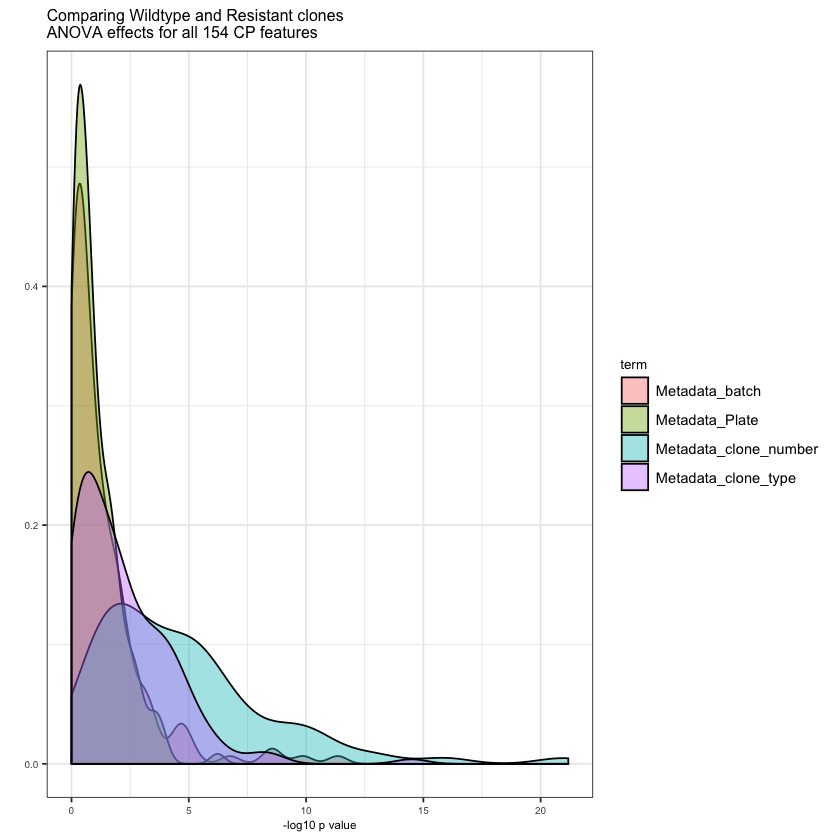

In [9]:
num_cp_features <- length(features)

difference_contribution_gg <- ggplot(
    full_results_df, aes(x = neg_log_p)
) +
    geom_density(aes(fill = term), alpha = 0.4) +
    theme_bw() +
    xlab("-log10 p value") +
    ylab("") +
    ggtitle(
        paste("Comparing Wildtype and Resistant clones\nANOVA effects for all", 
               num_cp_features,
              "CP features")) +
    theme(axis.text = element_text(size = 6),
          axis.title = element_text(size = 7),
          title = element_text(size = 8))

out_file <- file.path(output_fig_dir, "bulk_anova_effect_term_distributions.png")
ggsave(out_file, dpi = 500, height = 5, width = 4)

difference_contribution_gg

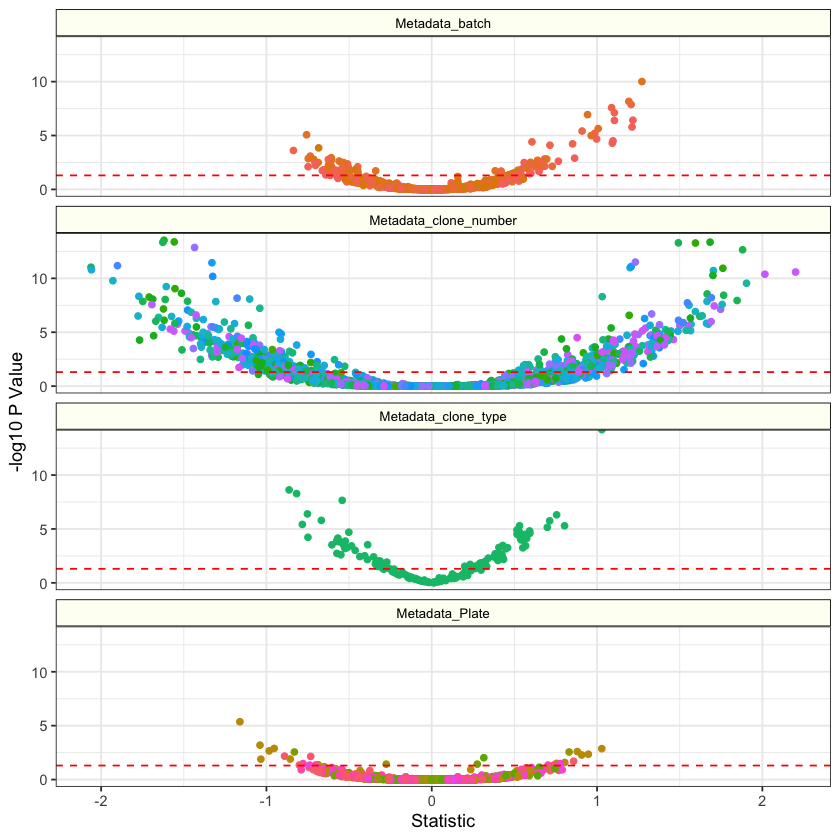

In [10]:
# Note that TukeyHSD() p value is already adjusted for multiple tests
signif_line <- -log10(0.05)

tukey_volcano_gg <- ggplot(full_tukey_results_df, aes(x = estimate, y = neg_log_adj_p)) +
    geom_point(aes(color = comparison)) +
    geom_hline(yintercept = signif_line, color = "red", linetype = "dashed") +
    facet_wrap("~term", nrow=length(unique(full_tukey_results_df$term))) +
    theme_bw() +
    xlab("Statistic") +
    ylab("-log10 P Value") +
    theme(
        strip.text = element_text(size = 8, color = "black"),
        strip.background = element_rect(colour = "black", fill = "#fdfff4"),
        legend.position="none"
    )

out_file <- file.path(output_fig_dir, "bulk_tukey_volcano.png")
ggsave(out_file, dpi = 500, height = 5, width = 4)

tukey_volcano_gg

### Identify Feature Signature

In [11]:
signature_features <- full_tukey_results_df %>%
    dplyr::filter(term == "Metadata_clone_type", neg_log_adj_p > !!signif_line) %>%
    dplyr::pull(feature)

feature_exclude_batch <- full_tukey_results_df %>%
    dplyr::filter(term == "Metadata_batch", neg_log_adj_p > !!signif_line) %>%
    dplyr::pull(feature)

feature_exclude_plate <- full_tukey_results_df %>%
    dplyr::filter(term == "Metadata_Plate", neg_log_adj_p > !!signif_line) %>%
    dplyr::pull(feature)

signature_features <- setdiff(signature_features, feature_exclude_batch)
signature_features <- setdiff(signature_features, feature_exclude_plate)

signature_features <- sort(signature_features)
print(length(signature_features))

[1] 51


In [12]:
bulk_signature_df <- full_results_df %>%
    dplyr::filter(feature %in% signature_features, term == "Metadata_clone_type")

bulk_tukey_signature_df <- full_tukey_results_df %>%
    dplyr::filter(feature %in% signature_features, term == "Metadata_clone_type")
colnames(bulk_tukey_signature_df) <- paste0(colnames(bulk_tukey_signature_df), "_tukey")

bulk_signature_df <- bulk_signature_df %>%
    dplyr::left_join(
        bulk_tukey_signature_df,
        by = c("term" = "term_tukey", "feature" = "feature_tukey"),
        suffix = c("", "_tukey")
    )

output_file <- file.path(output_results_dir, "bulk_signature.tsv")
bulk_signature_df %>% readr::write_tsv(output_file)

bulk_signature_df

Warning message:
“Column `term`/`term_tukey` joining factor and character vector, coercing into character vector”

term,df,sumsq,meansq,statistic,p.value,feature,neg_log_p,comparison_tukey,estimate_tukey,conf.low_tukey,conf.high_tukey,adj.p.value_tukey,neg_log_adj_p_tukey
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Metadata_clone_type,1,31.268926,31.268926,40.237230,2.380922e-09,Cytoplasm_Granularity_3_AGP,8.623255,sensitive-resistant,-0.8628431,-1.13155829,-0.594127925,2.380915e-09,8.623256
Metadata_clone_type,1,12.321542,12.321542,34.824616,2.216119e-08,Nuclei_AreaShape_Zernike_6_2,7.654407,sensitive-resistant,-0.5416365,-0.72295371,-0.360319207,2.216118e-08,7.654407
Metadata_clone_type,1,23.759175,23.759175,28.039284,4.035602e-07,Cells_AreaShape_Zernike_4_4,6.394092,sensitive-resistant,-0.7521267,-1.03272307,-0.471530415,4.035602e-07,6.394092
Metadata_clone_type,1,23.971288,23.971288,27.601015,4.888824e-07,Nuclei_Texture_InfoMeas1_Mito_10_00,6.310796,sensitive-resistant,0.7554766,0.47140170,1.039551586,4.888824e-07,6.310796
Metadata_clone_type,1,25.743751,25.743751,22.998650,3.793401e-06,Nuclei_Granularity_10_DNA,5.420971,sensitive-resistant,-0.7829090,-1.10541251,-0.460405409,3.793401e-06,5.420971
Metadata_clone_type,1,27.105247,27.105247,22.354372,5.080485e-06,Cells_Correlation_Manders_Mito_RNA,5.294095,sensitive-resistant,0.8033449,0.46768828,1.139001506,5.080485e-06,5.294095
Metadata_clone_type,1,10.563570,10.563570,19.370745,2.002073e-05,Cytoplasm_AreaShape_Zernike_8_4,4.698520,sensitive-resistant,-0.5015113,-0.72661463,-0.276407931,2.002073e-05,4.698520
Metadata_clone_type,1,14.797538,14.797538,18.891927,2.502327e-05,Cells_AreaShape_Zernike_9_7,4.601656,sensitive-resistant,0.5935675,0.32378957,0.863345349,2.502327e-05,4.601656
Metadata_clone_type,1,11.178091,11.178091,18.436214,3.096567e-05,Cells_AreaShape_Zernike_1_1,4.509120,sensitive-resistant,0.5158925,0.27853782,0.753247102,3.096567e-05,4.509120
